In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [16]:
df = pd.read_csv("mumbai_house_data_cleaned.csv")
df.head(2)

,bhk,type,locality,area,region,status,age,expected_roi(%),demand_indicator,market_volatitlity_score,property_liquidity_index,price_in_lakhs
0,3,Apartment,Lak And Hanware The Residency Tower,685,Andheri West,Ready to move,New,10.35,7.9,6.3,10.0,250.00
1,2,Apartment,Radheya Sai Enclave Building No 2,640,Naigaon East,Under Construction,New,9.25,7.8,7.4,10.0,52.51


MODEL DEVELOPMENT

In [17]:
# Encode categorical features
label_cols = ['type', 'locality', 'region', 'status', 'age']
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()

,bhk,type,locality,area,region,status,age,expected_roi(%),demand_indicator,market_volatitlity_score,property_liquidity_index,price_in_lakhs
0,3,0,3019,685,8,0,0,10.35,7.9,6.3,10.0,250.00
1,2,0,4965,640,124,1,0,9.25,7.8,7.4,10.0,52.51
2,2,0,7031,610,31,1,0,8.90,8.5,4.9,9.0,173.00
3,2,0,8484,876,140,1,0,9.96,6.1,3.4,8.9,59.98
4,2,0,4288,659,117,1,0,8.08,8.3,4.4,8.1,94.11


In [18]:
# Select Features and Target
features = ['bhk',
            'type',
            'locality',
            'area',
            'region',
            'status',
            'age',
            'demand_indicator',
            'market_volatitlity_score',
            'property_liquidity_index']

X = df[features]
y = df['price_in_lakhs']


In [19]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Train Models

In [20]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test) #predict

Evaluate the Models

In [21]:
# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

# Print neatly
print("--- Random Forest Regressor ---")
print(f"MAE: {mae:}")
print(f"MSE: {mse:}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:}")


--- Random Forest Regressor ---
MAE: 23.781254346396636
MSE: 5313.204044511503
RMSE: 72.89
R² Score: 0.8837347980581699


Risk Scoring Logic

In [22]:
# Normalize ROI to 0–10 scale
def normalize_roi(roi):
    min_roi = df['expected_roi(%)'].min()
    max_roi = df['expected_roi(%)'].max()
    return 10 * (roi - min_roi) / (max_roi - min_roi)
    
# Total risk score calculation
def risk_score(row):
    roi_norm = normalize_roi(row['expected_roi(%)']) # 0–10
    roi_risk = 10 - roi_norm # high ROI = low risk
    demand_risk = 10 - row['demand_indicator'] # high demand = low risk
    volatitlity_risk = row['market_volatitlity_score'] # high volatility = high risk
    liquidity_risk = 10 - row['property_liquidity_index']  # high liquidity = low risk
    
    # Average of all four components
    total_risk = (roi_risk + demand_risk + volatitlity_risk + liquidity_risk) / 4
    return round(total_risk, 2)

# Apply risk score to DataFrame
df['total_risk_score'] = df.apply(risk_score, axis=1)

# Add Risk Level
def risk_level(score):
    if score < 4:
        return "Low Risk"
    elif score <= 7:
        return "Moderate Risk"
    else:
        return "High Risk"

df['risk_level'] = df['total_risk_score'].apply(risk_level)

# Preview Risk Scoring Columns
df[['expected_roi(%)', 'demand_indicator', 'market_volatitlity_score',
    'property_liquidity_index', 'total_risk_score', 'risk_level']].head()

,expected_roi(%),demand_indicator,market_volatitlity_score,property_liquidity_index,total_risk_score,risk_level
0,10.35,7.9,6.3,10.0,3.09,Low Risk
1,9.25,7.8,7.4,10.0,3.63,Low Risk
2,8.90,8.5,4.9,9.0,3.15,Low Risk
3,9.96,6.1,3.4,8.9,3.18,Low Risk
4,8.08,8.3,4.4,8.1,3.48,Low Risk


In [23]:
print(df['risk_level'].value_counts())


risk_level
Low Risk         70507
Moderate Risk     5531
Name: count, dtype: int64


In [24]:
min_risk = df['total_risk_score'].min()
print("Low Risk Score:", min_risk)

max_risk = df['total_risk_score'].max()
print("Highest Risk Score:", max_risk)


Low Risk Score: 1.03
Highest Risk Score: 5.75


In [25]:
high_risk_df = df[df['risk_level'] == 'High Risk']
print("Number of High Risk Properties:", len(high_risk_df))


Number of High Risk Properties: 0


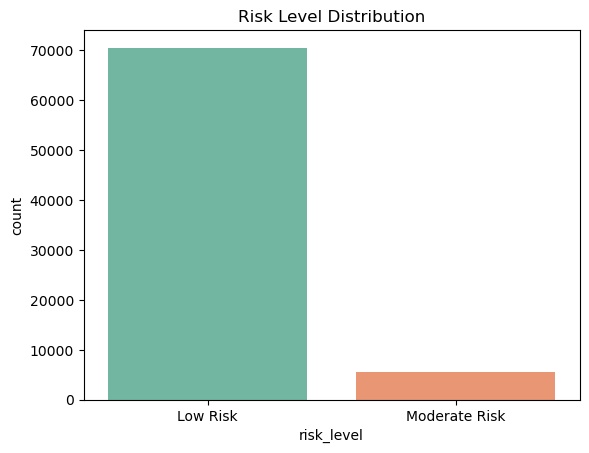

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='risk_level', hue='risk_level', data=df, palette='Set2')
plt.title("Risk Level Distribution")
plt.show()


In [27]:
# Save models
import joblib

joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(X.columns, "model_features.pkl")

['model_features.pkl']

In [28]:
df.head(10)

,bhk,type,locality,area,region,status,age,expected_roi(%),demand_indicator,market_volatitlity_score,property_liquidity_index,price_in_lakhs,total_risk_score,risk_level
0,3,0,3019,685,8,0,0,10.35,7.9,6.3,10.0,250.00,3.09,Low Risk
1,2,0,4965,640,124,1,0,9.25,7.8,7.4,10.0,52.51,3.63,Low Risk
2,2,0,7031,610,31,1,0,8.90,8.5,4.9,9.0,173.00,3.15,Low Risk
3,2,0,8484,876,140,1,0,9.96,6.1,3.4,8.9,59.98,3.18,Low Risk
4,2,0,4288,659,117,1,0,8.08,8.3,4.4,8.1,94.11,3.48,Low Risk
5,2,0,954,826,141,1,0,11.80,7.8,5.6,8.1,330.00,3.11,Low Risk
6,5,4,287,2921,28,1,0,12.78,7.6,4.1,8.4,199.00,2.50,Low Risk
7,3,0,7647,778,154,1,0,8.70,7.7,4.8,10.0,289.00,3.12,Low Risk
8,1,0,8319,396,15,0,0,9.58,6.9,6.5,8.3,29.84,3.98,Low Risk
9,2,0,499,671,51,1,0,9.91,6.0,3.9,9.7,272.00,3.14,Low Risk
